<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session4_attempt2/3_aug_lr_2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skeleton code


### Import Libraries


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

### Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(fill=(0,),degrees=(-7,7)), 
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

### Dataset and creating train/ test split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader arguments and test/ train dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model

In [5]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1)
        )  # ip = 28 | op = 26 | RF = 

        # CONVOLUTION BLOCK 
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(0.1)
        ) # ip = 26 | op = 24 | RF = 

        # TRANSITION BLOCK 
        self.transblock1 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=18, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
        ) # ip = 24 | op = 24 | RF = 
        self.pool1 = nn.MaxPool2d(2, 2) # ip = 24 | op = 12 | RF =

        # CONVOLUTION BLOCK 
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        ) # ip = 12 | op = 10 | RF = 

        # CONVOLUTION BLOCK 
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        ) # ip = 10 | op = 8 | RF =

        # CONVOLUTION BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        ) # ip = 8 | op = 6 | RF = 
        
        # GAP layer
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # ip = | op = | RF = 

        self.transblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # ip = 4 | op = 4 | RF = 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)
        x = self.transblock2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model parameters

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           1,728
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 18, 24, 24]             432
             ReLU-10           [-1, 18, 24, 24]               0
        MaxPool2d-11           [-1, 18, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           2,592

### Training and testing

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

### Train and test our model (step size 6)

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1488613784313202 Batch_id=468 Accuracy=85.59: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]



Test set: Average loss: 0.1298, Accuracy: 9626/10000 (96.26%)

EPOCH: 1


Loss=0.045155394822359085 Batch_id=468 Accuracy=96.87: 100%|██████████| 469/469 [00:19<00:00, 24.30it/s]



Test set: Average loss: 0.0752, Accuracy: 9777/10000 (97.77%)

EPOCH: 2


Loss=0.04810371622443199 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]



Test set: Average loss: 0.0377, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.03440588712692261 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]



Test set: Average loss: 0.0372, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.07745643705129623 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]



Test set: Average loss: 0.0379, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


Loss=0.02564447559416294 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]



Test set: Average loss: 0.0306, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.00929197482764721 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.03813609480857849 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]



Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.021139517426490784 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.026931986212730408 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]



Test set: Average loss: 0.0249, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.010871455073356628 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]



Test set: Average loss: 0.0245, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.022618116810917854 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]



Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.010331324301660061 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0240, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.012644118629395962 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]



Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.016170762479305267 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]



Test set: Average loss: 0.0228, Accuracy: 9935/10000 (99.35%)



##### Plotting

Text(0.5, 1.0, 'Test Accuracy')

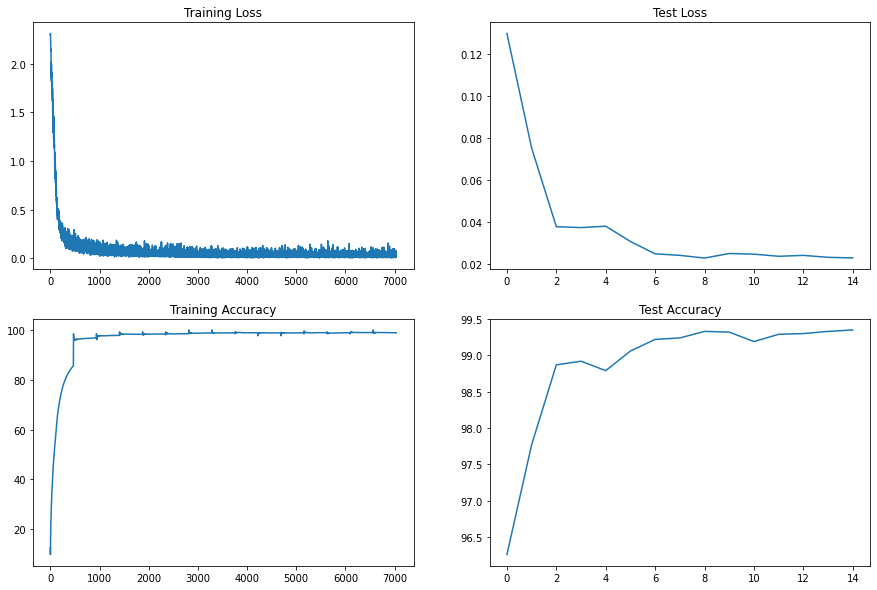

In [9]:
import numpy as np
fig, axs = plt.subplots(2,2,figsize=(15,10))
#train_losses=plt.plot(list(range(len(train_loss))),train_loss.cpu().detach().numpy(),color="r",label="Train "+typ)
#print (train_losses)
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")